```
This notebook marks the Oslofjord and its open ocean connection
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if p.endswith("gpuocean/src")][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# Oslofjord

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["image.origin"] = "lower"

In [2]:
def latlon2xy(lats, lons, lat, lon, dx=800.0, dy=800.0):
    penalty = (lats - lat)**2 + (lons - lon)**2
    idx_y, idx_x = np.argwhere( penalty==penalty.min() )[0]

    if lats[idx_y, idx_x] > lat:
        idx_y_lower = idx_y-1
        idx_y_upper = idx_y 
    else:
        idx_y_lower = idx_y 
        idx_y_upper = idx_y+1

    if lons[idx_y, idx_x] > lon:
        idx_x_lower = idx_x-1
        idx_x_upper = idx_x 
    else:
        idx_x_lower = idx_x  
        idx_x_upper = idx_x+1

    y = idx_y_lower + (lat - lats[idx_y_lower, idx_x])/(lats[idx_y_upper, idx_x] - lats[idx_y_lower, idx_x])
    x = idx_x_lower + (lon - lons[idx_y, idx_x_lower])/(lons[idx_y, idx_x_upper] - lons[idx_y, idx_x_lower])

    return (y-0.5)*dy/1000, (x-0.5)*dx/1000

In [48]:
source_url = "/sintef/data/NorKyst800/ocean_his.an.20190716.nc"
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    lats = np.array(ncfile.variables["lat_rho"])
    lons = np.array(ncfile.variables["lon_rho"])
    land_mask = 1-ncfile["mask_rho"][:]
except Exception as e:
    raise e

finally:
    ncfile.close()

print(land_mask.shape)

(902, 2602)


In [79]:
nk_x0=225
nk_x1=575
nk_y0=0
nk_y1=250

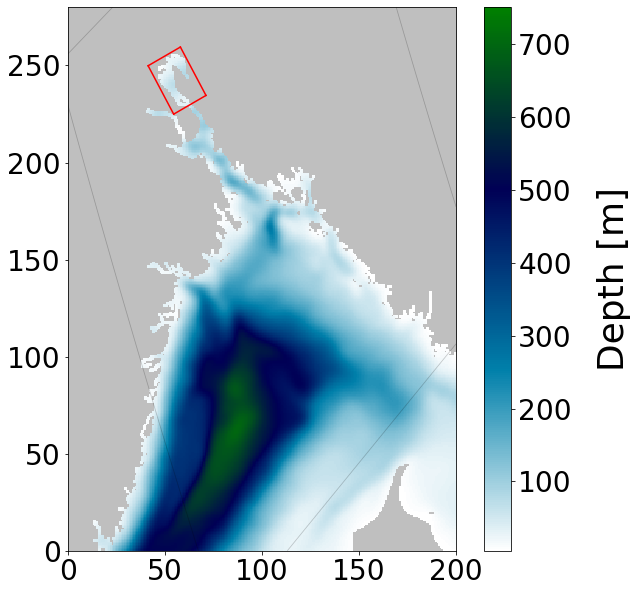

In [126]:

(full_ny, full_nx) = H_full.shape

# Makes sure axis are in km (assuming equidistant 800x800m grid)
extent=np.array([nk_y1*0.8, nk_y0*0.8, nk_x0*0.8, nk_x1*0.8])


fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(axis='both', which='major', labelsize=28)

ax.set_yticks([nk_x0*0.8, nk_x0*0.8+50, nk_x0*0.8+100, nk_x0*0.8+150, nk_x0*0.8+200, nk_x0*0.8+250])
ax.set_yticklabels([0, 50, 100, 150, 200, 250])

ax.set_xticks([0, 50, 100, 150, 200])
ax.set_xticklabels([200, 150, 100, 50, 0])


# Land and bathymetry
land = np.ma.masked_where(land_mask, H_full)

cmap = copy.copy(plt.cm.ocean_r)
cmap.set_bad("grey", alpha=0.5)

im = ax.imshow(np.flip(land[nk_y0:nk_y1, nk_x0:nk_x1], axis=0).T, interpolation="None", cmap=cmap,
            extent=extent, vmax=750)

cbar = fig.colorbar(im, aspect=20, shrink=1)
cbar.set_label('Depth [m]', size=36, labelpad=25)
cbar.ax.tick_params(labelsize=28)

ax.contour(lons[nk_y0:nk_y1, nk_x0:nk_x1], levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
ax.contour(lats[nk_y0:nk_y1, nk_x0:nk_x1], levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

red = "red"

# OSLO

source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

try: 
    nc = Dataset(source_url)

    ds = xr.open_dataset(source_url)
    dimY, dimX = ds.h.data.shape
    x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

    lon00 = nc["lon_rho"][y0:y1,x0:x1][ 0,-1]
    lon01 = nc["lon_rho"][y0:y1,x0:x1][ 0, 0]
    lon10 = nc["lon_rho"][y0:y1,x0:x1][-1,-1]
    lon11 = nc["lon_rho"][y0:y1,x0:x1][-1, 0]
    
    lat00 = nc["lat_rho"][y0:y1,x0:x1][ 0,-1]
    lat01 = nc["lat_rho"][y0:y1,x0:x1][ 0, 0]
    lat10 = nc["lat_rho"][y0:y1,x0:x1][-1,-1]
    lat11 = nc["lat_rho"][y0:y1,x0:x1][-1, 0]
except: 
    pass
finally:
    nc.close()

xy00 = latlon2xy(lats, lons, lat00, lon00)
xy01 = latlon2xy(lats, lons, lat01, lon01)
xy10 = latlon2xy(lats, lons, lat10, lon10)
xy11 = latlon2xy(lats, lons, lat11, lon11)


ax.plot([xy00[0],xy01[0]], [xy00[1],xy01[1]], color=red)
ax.plot([xy01[0],xy11[0]], [xy01[1],xy11[1]], color=red)
ax.plot([xy11[0],xy10[0]], [xy11[1],xy10[1]], color=red)
ax.plot([xy10[0],xy00[0]], [xy10[1],xy00[1]], color=red)


plt.savefig("Oslofjord-overview.pdf", bbox_inches="tight")